### Data Collection
##### Sukumar Hakhoo 
##### Dibyajit Banerjee

In [1]:
from configuration_generator import Configurations

In [2]:
c = Configurations()

In [3]:
c.generateConfigurations()

#### PyTorch Trainer

In [1]:
%run trainer_pytorch.py -c "0,1" -d "data/" -s "training_data/"

CUDA Toolkit available for PyTorch
GPU: GeForce GTX 1050 Ti

Loading train data
Files already downloaded and verified

Loading test data
Files already downloaded and verified

########################################
# Running configuration: 0  
########################################

########################################
# resnet18 on GeForce GTX 1050 Ti 
########################################
Updated last layer: fc
Epoch 1/1                                                                                                                                             
----------
#############################################################    Loss=2.291, Accuracy=17.652%

Training data saved successfully.


########################################
# Running configuration: 1  
########################################

########################################
# resnet18 on GeForce GTX 1050 Ti 
########################################
Updated last layer: fc
Epoch 1/1                  

In [1]:
%run trainer_pytorch.py -d data/ -e 1 -s training_data/

CUDA Toolkit available for PyTorch
GPU: GeForce GTX 1050 Ti

Loading train data
Files already downloaded and verified

Loading test data
Files already downloaded and verified

########################################
# resnet18 on GeForce GTX 1050 Ti 
########################################
Updated last layer: fc
Epoch 1/1                                                                                                                                             
----------
##################################################################    Loss=2.181, Accuracy=19.252%

Training data saved successfully.


In [ ]:
%run trainer_pytorch.py -d "data/" -s "training_data/" -w 0 -e 3 -b 32 -lr 0.1

Data Parallel

In [ ]:
import torch.nn as nn

In [ ]:
model_p = nn.DataParallel(model)

#### Distributed Data Parallel

In [5]:
import os
import sys
import pickle
import argparse
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision import datasets, models, transforms

from configuration_generator import Configurations

import torch.distributed as dist
import torch.multiprocessing as mp

from torch.nn.parallel import DistributedDataParallel as DDP

In [ ]:
from trainer_pytorch import *

In [ ]:
train_data, test_data = load_cifar10_dataset()

In [13]:
def setup(rank, world_size):
    if sys.platform == 'win32':
        # Distributed package only covers collective communications with Gloo
        # backend and FileStore on Windows platform. Set init_method parameter
        # in init_process_group to a local file.
        # Example init_method="file:///f:/libtmp/some_file"
        init_method="file:///C:\\Users\\sukum\\Documents\\Grad\\Cloud and ML\\Homeworks\\Project 2\\Code\\distributed-training\\Data Collection\\file"

        # initialize the process group
        dist.init_process_group(
            "gloo",
            init_method=init_method,
            rank=rank,
            world_size=world_size
        )
    else:
        os.environ['MASTER_ADDR'] = 'localhost'
        os.environ['MASTER_PORT'] = '12355'

        # initialize the process group
        # dist.init_process_group("gloo", rank=rank, world_size=world_size)
        dist.init_process_group("nccl", rank=rank, world_size=world_size)

In [14]:
def cleanup():
    dist.destroy_process_group()

In [ ]:
def _test(cnn, criterion):        
    cnn.eval()
    correct, total = 0., 0.
    xentropy_loss_avg_val = 0.

    test_start_time = time()
    for i, (images, labels) in enumerate(test_loader):
        images = images.cuda()
        labels = labels.cuda()

        with torch.no_grad():
            pred = cnn(images)

        xentropy_loss = criterion(pred, labels)
        xentropy_loss_avg_val += xentropy_loss.item() 

        pred = torch.max(pred.data, 1)[1]
        total += labels.size(0)
        correct += (pred == labels).sum().item()

    training_log['test_timings'].append(time() - test_start_time)
    training_log['test_error'].append(xentropy_loss_avg_val / (i + 1))
    val_acc = correct / total
    cnn.train()
    return val_acc

In [1]:
def train(rank, world_size):
    """
    Train function

    Capture the training statistics
    num_epochs - No. of epochs
    """
    print(f'Setting up DDP for rank {rank}.')
    setup(rank, world_size)
    torch.cuda.set_device(rank)
    
    config = load_config()
    config['learning_rate'] = 0.1
    config['batch_size'] = 512
    
    train_loader, test_loader = get_dataloaders(train_data, test_data, config)
    
    training_log = {'train_acc': [],
                     'test_acc': [],
                     'train_loss': [],
                     'test_error': [],
                     'epoch_timings': [],
                     'test_timings': []
                    }

    model = DDP(models.__getattribute__(config['model_name'])(), device_ids=[rank], output_device=rank)
    
    config['num_of_paramters'] = sum(p.numel() for p in model.parameters())
    config['gpu'] = torch.cuda.get_device_name()
    
    num_epochs = 10
    print('\n' + ('#' * 40) + 
          '\n# {} on {} \n'.format(config['model_name'], 
                                   config['gpu']) + 
          ('#' * 40))
    if 'fc' in model.__dir__():
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, len(train_loader.dataset.classes))
        print(f'Updated last layer: fc')
    elif 'classifier' in model.__dir__():
        last_layer = len(model.classifier) - 1
        num_ftrs = model.classifier[last_layer].in_features
        model.classifier[last_layer] = nn.Linear(num_ftrs, len(train_loader.dataset.classes))
        print(f'Updated last layer: classifier[{last_layer}]')

    cnn = model.cuda()
    criterion = nn.CrossEntropyLoss().cuda()
    cnn_optimizer = optim.SGD(cnn.parameters(),
                              lr=config['learning_rate'],
                              momentum=config['momentum'], 
                              nesterov=True,
                              weight_decay=config['weight_decay'])
    scheduler = lr_scheduler.MultiStepLR(cnn_optimizer, 
                                         list(map(lambda x: int(x), 
                                                  config['milestones'].split(','))),
                                         gamma=config['gamma'])

    print_bound, print_output = 3, True
    p = len(train_loader) // 60

    training_start_time = time()
    for epoch in range(num_epochs):
        epoch_start_time = time()

        if epoch < print_bound or epoch >= num_epochs - print_bound:
            print_output = True
        elif epoch == print_bound:
            print('.\n.\n.\n')
            print_output = False

        __print__, __result__ = '', ''
        print(' ' * 150, end='\r')
        if print_output:
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 10)
        else:
            __print__ = f'Epoch {epoch + 1}/{num_epochs}: '
            print(__print__, end='\r')

        xentropy_loss_avg = 0.
        correct = 0.
        total = 0.

        for i, (images, labels) in enumerate(train_loader):

            if i % p == 0:
                __print__ += '#'
                print(__print__ + __result__, end='\r')

            images = images.cuda()
            labels = labels.cuda()

            cnn.zero_grad()
            pred = cnn(images)

            xentropy_loss = criterion(pred, labels)
            xentropy_loss.backward()
            cnn_optimizer.step()

            xentropy_loss_avg += xentropy_loss.item()

            # Calculate running average of accuracy
            pred = torch.max(pred.data, 1)[1]
            total += labels.size(0)
            correct += (pred == labels.data).sum().item()
            accuracy = correct / total

            __result__ = '    Loss=%.3f, Accuracy=%.3f' % (xentropy_loss_avg / (i + 1), 
                                                           accuracy*100) + '%'
            print(__print__ + __result__, end='\r')


        test_acc = _test(cnn, criterion)
        if print_output:
            print('\n')

        scheduler.step()

        training_log['epoch_timings'].append(time() - epoch_start_time)
        training_log['train_acc'].append(accuracy)
        training_log['test_acc'].append(test_acc)
        training_log['train_loss'].append(xentropy_loss_avg / (i + 1))
    
    cleanup()

In [ ]:
# torch.cuda.device_count()

mp.spawn(train, 
         args=(world_size,),
         nprocs=world_size,
         join=True)

In [15]:
def trainer(rank, world_size):
    print(f"Running DDP on rank {rank}.")
    setup(rank, world_size)

    # create model and move it to GPU with id rank
    # model = ToyModel().to(rank)
    model = models.__getattribute__(config['model_name'])().to(rank)
    ddp_model = DDP(model, device_ids=[rank])

    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(ddp_model.parameters(), lr=0.001)

    optimizer.zero_grad()
    outputs = ddp_model(torch.randn(20, 10))
    labels = torch.randn(20, 5).to(rank)
    loss_fn(outputs, labels).backward()
    optimizer.step()

    cleanup()

In [1]:
c= {}

In [2]:
a = c.copy()

In [ ]:
# model = models.__getattribute__(config['model_name'])()

In [ ]:
# config['num_of_paramters'] = sum(p.numel() for p in model_p.parameters())
# config['gpu'] = torch.cuda.get_device_name()

In [16]:
def run_demo(train_fn, world_size):
    mp.spawn(train_fn,
             args=(world_size,),
             nprocs=world_size,
             join=True)

In [ ]:
run_demo(trainer, 1)

In [ ]:
if __name__ == "__main__":
    n_gpus = torch.cuda.device_count()
    if n_gpus < 8:
        print(f"Requires at least 8 GPUs to run, but got {n_gpus}.")
    else:
        run_demo(demo_basic, 8)
        #run_demo(demo_checkpoint, 8)
        #run_demo(demo_model_parallel, 4)

In [1]:
import torch.multiprocessing as mp

In [7]:
def simple(rank, world_size, arg1, arg2):
    setup(rank, world_size)
    print(f'Arg 1 = {arg1}')
    print(f'Arg 2 = {arg2}')
    print(f'World size = {world_size}')
    print(f'World size = {rank}')

In [10]:
mp.spawn(simple, 
         args=(1, "argument1", "argument2", ),
         nprocs=1,
         join=False
        )

###  Tensorflow

In [1]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Flatten, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adagrad, RMSprop, Adadelta, Adam, Nadam
import matplotlib.pyplot as plt
from time import time
from IPython.display import clear_output
from itertools import accumulate

Loading dataset

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
print('Training feature set shape: ' + str(x_train.shape))
print('Training label set shape: ' + str(y_train.shape))
print('Test feature set shape: ' + str(x_test.shape))
print('Test label set shape: ' + str(y_test.shape))

Training feature set shape: (50000, 32, 32, 3)
Training label set shape: (50000, 1)
Test feature set shape: (10000, 32, 32, 3)
Test label set shape: (10000, 1)


In [4]:
x_train = x_train[:5000]
y_train = y_train[:5000]
x_test = x_test[:2000]
y_test = y_test[:2000]

In [5]:
# Set numeric type to float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize feature values
x_train /= 255
x_test /= 255

# Transform lables to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Reshape the dataset into 4D array
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)

In [6]:
class timer(Callback):
    def __init__(self):
        self.epoch_timings = []
        self.total_time_at_epochs = []
        self.training_time = 0
        
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time()
        
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_timings.append(time() - self.epoch_start)
        
    def on_train_begin(self, logs=None):
        self.training_start = time()
        
    def on_train_end(self, logs=None):
        self.training_time = time() - self.training_start
        self.total_time_at_epochs = list(accumulate(self.epoch_timings))

In [7]:
def run_trainings(layers = None):
    results = {}
    
    for method in [0.01,0.001,0.0001]:
        print(f'Training with Learning Rate: {method}')
        results[method], t = {}, timer()
        model = Sequential(layers)
        model.compile(optimizer=RMSprop(learning_rate=method),
                      loss=CategoricalCrossentropy(),
                      metrics=['accuracy'])
        history = model.fit(
            x = x_train,
            y = y_train,
            batch_size = 128,
            epochs = 25,
            validation_data = (x_test, y_test),
            verbose = 0,
            callbacks=[t]
        )

        results[method]['test_performance'] = model.evaluate(x=x_test, y=y_test)
        results[method]['accuracy'] = history.history['accuracy']
        results[method]['loss'] = history.history['loss']
        results[method]['total_time_at_epochs'] = t.total_time_at_epochs
        results[method]['training_time'] = t.training_time
        results[method]['epoch_timings'] = t.epoch_timings
        
        print('\n')
    
    return results

In [8]:
def visualize_training(results, opts='-', title='Adaptive Learning Rate Methods'):
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(24, 6))
    fig.suptitle(title, fontsize=16)

    for method in results:
        ax[0].plot([None] + results[method]['accuracy'], opts, label=method)
    ax[0].legend(loc = 'best')
    ax[0].set_title('Training Accuracy per Epoch')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    #ax[0].set_ylim(0.2, 0.8)

    for method in results:
        ax[1].plot([None] + results[method]['loss'], opts, label=method)
    ax[1].legend(loc = 'best')
    ax[1].set_title('Training Loss per Epoch')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    #ax[1].set_ylim(1, 4.5)
    
    for method in results:
        ax[2].plot([None] + results[method]['total_time_at_epochs'], opts, label=method)
    ax[2].legend(loc = 'best')
    ax[2].set_title('Total Training Time at Epoch')
    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel('Training Time')
    # ax[2].set_ylim(-100, 950)

    for method in results:
        ax[3].plot([None] + results[method]['epoch_timings'], opts, label=method)
    ax[3].legend(loc = 'best')
    ax[3].set_title('Epoch Timing')
    ax[3].set_xlabel('Epoch')
    ax[3].set_ylabel('Training Time')
    # ax[2].set_ylim(-100, 950)

    fig.tight_layout()
    plt.show()

In [9]:
layers = [ 
    Flatten(input_shape=(32, 32, 3)),
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(10, activation='softmax')
]

In [27]:
results = run_trainings(layers)

Training with Adagrad
63/63 [==============================] - 0s 3ms/step - loss: 4.3705 - accuracy: 0.3375


Training with RMSprop
63/63 [==============================] - 0s 3ms/step - loss: 1.9926 - accuracy: 0.3320




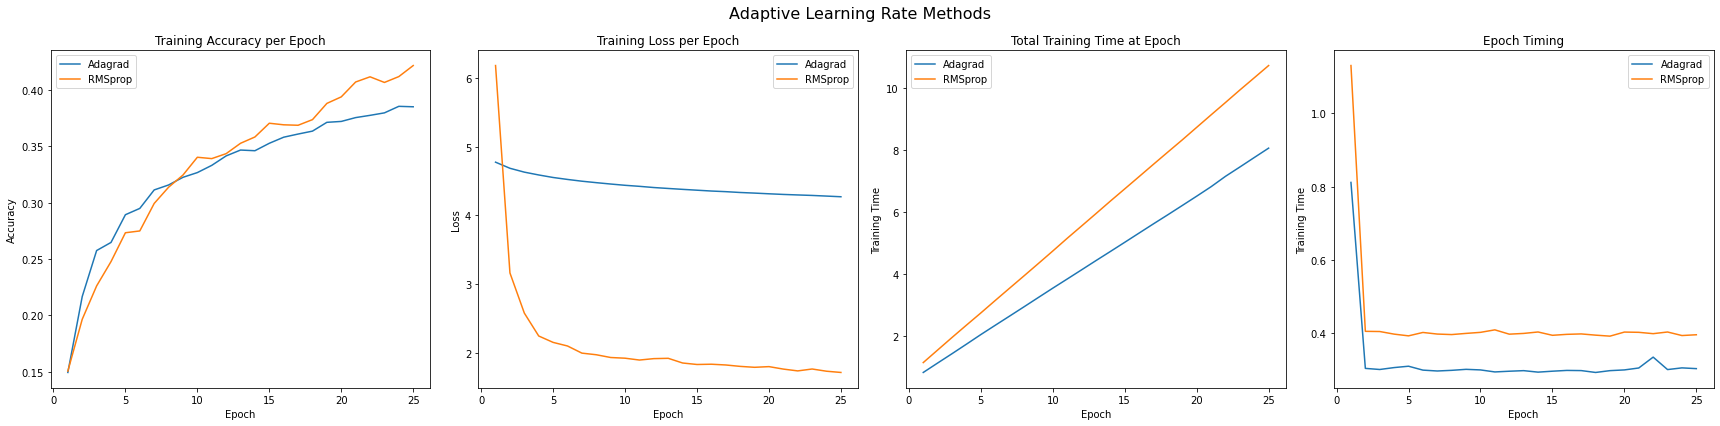

In [32]:
visualize_training(results)

In [10]:
results = run_trainings(layers)

Training with Batch Size: 32
63/63 [==============================] - 0s 3ms/step - loss: 2.0652 - accuracy: 0.3475


Training with Batch Size: 64
63/63 [==============================] - 0s 3ms/step - loss: 2.3763 - accuracy: 0.3620


Training with Batch Size: 128
63/63 [==============================] - 0s 3ms/step - loss: 2.6312 - accuracy: 0.3400




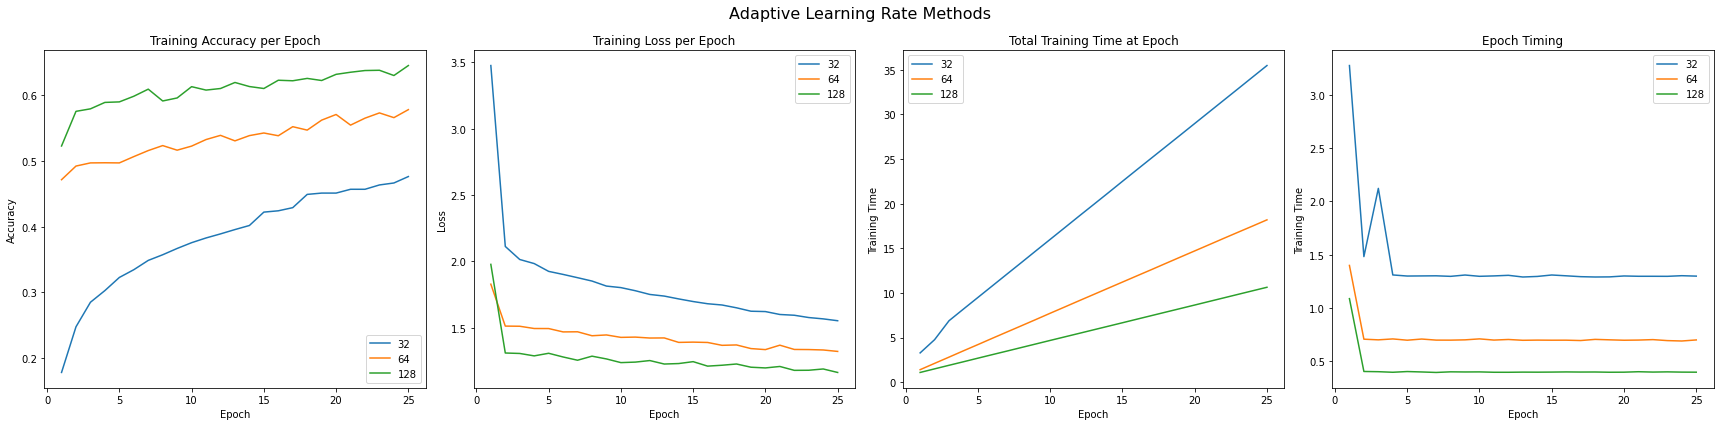

In [11]:
visualize_training(results)

In [10]:
results = run_trainings(layers)

Training with Learning Rate: 0.01
63/63 [==============================] - 0s 4ms/step - loss: 2.4017 - accuracy: 0.0975


Training with Learning Rate: 0.001
63/63 [==============================] - 0s 3ms/step - loss: 2.3034 - accuracy: 0.0990


Training with Learning Rate: 0.0001
63/63 [==============================] - 0s 4ms/step - loss: 2.3025 - accuracy: 0.0990




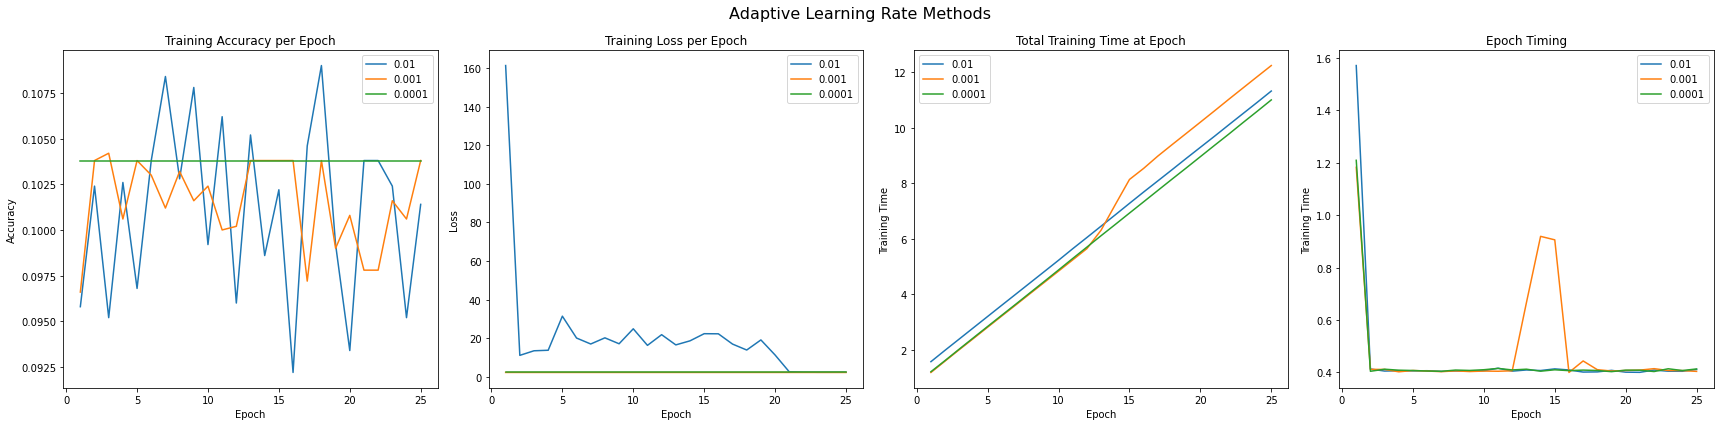

In [11]:
visualize_training(results)